In [1]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA & Cleaning

In [ ]:
df=pd.read_pickle("LSWMD.pkl")

def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

In [ ]:
df.sample(10)

In [ ]:
df.isna().sum()

In [ ]:
df_ = df.TrainTestLabel.dropna()
# df_ = df_.failureType.dropna()
df_

* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)

In [ ]:
df.sample(5)

In [ ]:
df.shape[0]
# failureType: 811457 -> 172950

In [ ]:
df

In [ ]:
df_ = df.dropna(subset=['failureType'])

In [ ]:
df_

In [ ]:
max(df_.waferMapDim), min(df_.waferMapDim)

In [ ]:
uni_waferDim=np.unique(df_.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]
# 632개의 서로다른 Wafer map size 가 존재.

In [ ]:
df_.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 

* For this reason, we must do **data tranformation** (feature extraction) to **make input the same dim** and the method will be introduced in the following section.

>**Missing value check**
* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [ ]:
df['failureNum']=df.failureType
df['trainTestNum']=df.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
df

In [ ]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

In [ ]:
df_withlabel

In [ ]:
df_withpattern
# none 제거 버전

In [ ]:
df_nonpattern
# failuretype: none

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
no_wafers=[df.shape[0]-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [ ]:
# with labeled - failuretype
label = df_withlabel.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
label = df_withpattern.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
df_withpattern.failureType.value_counts()

In [ ]:
# None 클래스 Undersampling
none = df_withlabel.loc[(df_withlabel.failureType == 'none'),:].sample(10000)
df_withlabel.drop(df_withlabel[df_withlabel.failureType == 'none'].index, inplace = True)
print(none.shape)
print(df_withlabel.shape)

df_withlabel_new = pd.concat([df_withlabel, none], ignore_index=True)
df_withlabel_new.shape

In [ ]:
label = df_withlabel_new.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
df_withlabel_new['failureType'].value_counts()

In [ ]:
df_withpattern.waferMapDim[0][0]

In [ ]:
def find_size(x):
    w = x[0]
    h = x[1]
    return np.sqrt(w*h)
    
df_withlabel['wafermaplen'] = df_withlabel.waferMapDim.apply(find_size)

In [ ]:
print(df_withlabel.wafermaplen.median())
print(df_withlabel.wafermaplen.mean())

In [ ]:
plt.hist(df_withlabel.wafermaplen, bins=20)
plt.show()

## Visualize

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withlabel.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_withlabel.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withlabel.waferMap[df_withlabel.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withlabel.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_withlabel.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
df_withlabel.waferMap.values[0]

In [ ]:
df_withlabel.failureNum.values

In [ ]:
X = df_withlabel_new.waferMap.values
y = df_withlabel_new.failureNum.values
assert X.shape[0] == y.shape[0]

In [ ]:
df_withlabel_new.failureNum.unique()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

# train, val, test = 0.7, 0.15, 0.15

In [ ]:
# torch.save(X_train, 'Data/X_train_new.pt')
# torch.save(X_val, 'Data/X_val_new.pt')
# torch.save(X_test, 'Data/X_test_new.pt')
# torch.save(y_train, 'Data/y_train_new.pt')
# torch.save(y_val, 'Data/y_val_new.pt')
# torch.save(y_test, 'Data/y_test_new.pt')

# Config

In [2]:
# Load
X_train = torch.load('Data/X_train_new.pt')
X_val = torch.load('Data/X_val_new.pt')
X_test = torch.load('Data/X_test_new.pt')
y_train = torch.load('Data/y_train_new.pt')
y_val = torch.load('Data/y_val_new.pt')
y_test = torch.load('Data/y_test_new.pt')

In [3]:
BATCH_SIZE_TRAIN = 256  # 32 -> 256
BATCH_SIZE_VAL = 512
BATCH_SIZE_TEST = 512

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 80

save_name = f'resnet50_batch{BATCH_SIZE_TRAIN}_aug_focal'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda:0")
print(save_name, save_path)

resnet50_batch256_aug_focal models/resnet50_batch256_aug_focal.pt


# Dataset

In [ ]:
# temp_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
# data = next(iter(temp_loader))

# mean = data['img'][:, 0].float().mean().numpy()
# print(mean)

In [4]:
from albumentations.pytorch.transforms import ToTensorV2
from utils import get_transforms, display_aug
# Transforms and Dataset

class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

train_transform, else_transform = get_transforms(size=RE_SIZE)

train_dataset = WaferDataset(X_train, y_train, transform=train_transform)
val_dataset = WaferDataset(X_val, y_val, transform=else_transform)
test_dataset = WaferDataset(X_test, y_test, transform=else_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

24863 5328 5328


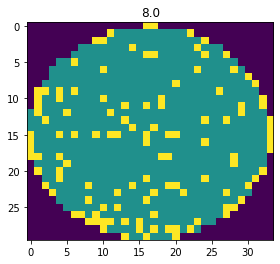

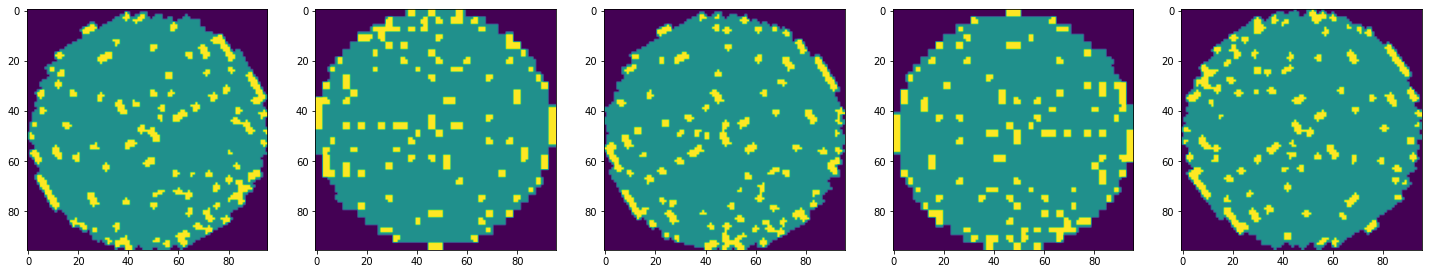

In [5]:
display_aug(imgs=X_train, transform=train_transform, labels = y_train)

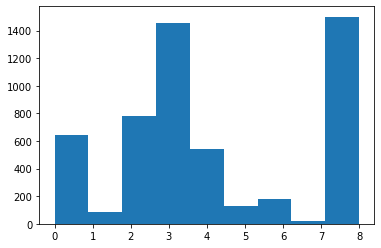

In [7]:
plt.hist(y_test, bins=9)
plt.show()

# Model

In [8]:
from torchvision.models import resnet50
from torchinfo import summary

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE_TRAIN, INPUT_CH, RE_SIZE, RE_SIZE), device='cpu')

In [9]:
weights = torch.tensor([0.25]).expand(NUM_CLASSES)
weights

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500])

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils import FocalLoss

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# criterion = FocalLoss(weights=weights.cuda(), gamma=2, reduce=True) # ERROR!
criterion = FocalLoss(weights=weights.cuda(), gamma=2, reduce=True) # ERROR!
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=5, threshold_mode='rel', verbose=True)

In [11]:
from sklearn.metrics import f1_score 

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    for batch_idx, batch in tqdm_loader:
        img = batch['img'].float().cuda()
        label = batch['label'].long().cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # mixed precision + gradient clipping
        with torch.cuda.amp.autocast():
            output = model(img).cuda()
            loss = criterion(output, label)

        scaler.scale(loss).backward() 
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        scaler.step(optimizer)
        scaler.update()
        
        # # forward + backward + optimize
        # output = model(img)
        # loss = criterion(output, label)
        # loss.backward()
        # optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            img = batch['img'].float().cuda()   
            label = batch['label'].long().cuda()
            output = model(img).cuda()
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            # tqdm_loader.set_postfix({
            #     'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            #     'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            #     'Batch Loss': '{:06f}'.format(loss.item()),
            #     'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            #     'Batch ACC': '{:06f}'.format(correct / len(label)),
            #     'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            # })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_macro_list.append(epoch_f1_macro)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_f1_macro_list) == val_f1_macro_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)   # weighted F1 기준


# Train

In [12]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

model.to(device)

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

98it [00:13,  7.13it/s, Epoch=1/80, Batch=98/98, Batch Loss=0.057848, Mean Loss=0.048326, Batch ACC=0.516129, Mean ACC=0.508989]


Train loss: 0.048326, Train ACC: 0.508989, F1_macro: 0.301696, F1_weighted: 0.445445 lr: 0.000100
Valid loss: 0.037058, Valid ACC: 0.600976, F1_macro: 0.382423, F1_weighted: 0.552890
3202/5328 correct


98it [00:10,  8.92it/s, Epoch=2/80, Batch=98/98, Batch Loss=0.023590, Mean Loss=0.031505, Batch ACC=0.612903, Mean ACC=0.645176]


Train loss: 0.031505, Train ACC: 0.645176, F1_macro: 0.452641, F1_weighted: 0.600428 lr: 0.000100
Valid loss: 0.026852, Valid ACC: 0.670233, F1_macro: 0.469344, F1_weighted: 0.646695
3571/5328 correct


98it [00:10,  9.18it/s, Epoch=3/80, Batch=98/98, Batch Loss=0.029878, Mean Loss=0.024296, Batch ACC=0.709677, Mean ACC=0.703535]


Train loss: 0.024296, Train ACC: 0.703535, F1_macro: 0.542018, F1_weighted: 0.676477 lr: 0.000100
Valid loss: 0.020207, Valid ACC: 0.739677, F1_macro: 0.604513, F1_weighted: 0.716945
3941/5328 correct


98it [00:10,  9.16it/s, Epoch=4/80, Batch=98/98, Batch Loss=0.023453, Mean Loss=0.019074, Batch ACC=0.709677, Mean ACC=0.753127]


Train loss: 0.019074, Train ACC: 0.753127, F1_macro: 0.630565, F1_weighted: 0.733474 lr: 0.000100
Valid loss: 0.016328, Valid ACC: 0.779655, F1_macro: 0.646643, F1_weighted: 0.764885
4154/5328 correct


98it [00:10,  9.19it/s, Epoch=5/80, Batch=98/98, Batch Loss=0.028048, Mean Loss=0.015927, Batch ACC=0.612903, Mean ACC=0.783936]


Train loss: 0.015927, Train ACC: 0.783936, F1_macro: 0.675529, F1_weighted: 0.767203 lr: 0.000100
Valid loss: 0.012788, Valid ACC: 0.815315, F1_macro: 0.716151, F1_weighted: 0.800999
4344/5328 correct


98it [00:10,  9.12it/s, Epoch=6/80, Batch=98/98, Batch Loss=0.016865, Mean Loss=0.013336, Batch ACC=0.870968, Mean ACC=0.812492]


Train loss: 0.013336, Train ACC: 0.812492, F1_macro: 0.689089, F1_weighted: 0.797177 lr: 0.000100
Valid loss: 0.011556, Valid ACC: 0.834084, F1_macro: 0.709999, F1_weighted: 0.817623
4444/5328 correct


98it [00:10,  9.10it/s, Epoch=7/80, Batch=98/98, Batch Loss=0.020727, Mean Loss=0.011517, Batch ACC=0.741935, Mean ACC=0.832603]


Train loss: 0.011517, Train ACC: 0.832603, F1_macro: 0.714862, F1_weighted: 0.819593 lr: 0.000100
Valid loss: 0.010051, Valid ACC: 0.853979, F1_macro: 0.748116, F1_weighted: 0.838364
4550/5328 correct


98it [00:10,  9.19it/s, Epoch=8/80, Batch=98/98, Batch Loss=0.008537, Mean Loss=0.009893, Batch ACC=0.838710, Mean ACC=0.845393]


Train loss: 0.009893, Train ACC: 0.845393, F1_macro: 0.734590, F1_weighted: 0.834484 lr: 0.000100
Valid loss: 0.008919, Valid ACC: 0.856982, F1_macro: 0.760200, F1_weighted: 0.842503
4566/5328 correct


98it [00:10,  9.19it/s, Epoch=9/80, Batch=98/98, Batch Loss=0.008612, Mean Loss=0.008871, Batch ACC=0.903226, Mean ACC=0.859470]


Train loss: 0.008871, Train ACC: 0.859470, F1_macro: 0.765733, F1_weighted: 0.850776 lr: 0.000100
Valid loss: 0.008022, Valid ACC: 0.874437, F1_macro: 0.778521, F1_weighted: 0.867386
4659/5328 correct


98it [00:10,  9.21it/s, Epoch=10/80, Batch=98/98, Batch Loss=0.007614, Mean Loss=0.008291, Batch ACC=0.806452, Mean ACC=0.865061]


Train loss: 0.008291, Train ACC: 0.865061, F1_macro: 0.770443, F1_weighted: 0.858353 lr: 0.000100
Valid loss: 0.009742, Valid ACC: 0.868806, F1_macro: 0.684025, F1_weighted: 0.859000
4629/5328 correct


98it [00:10,  9.12it/s, Epoch=11/80, Batch=98/98, Batch Loss=0.008298, Mean Loss=0.007828, Batch ACC=0.870968, Mean ACC=0.869324]


Train loss: 0.007828, Train ACC: 0.869324, F1_macro: 0.779172, F1_weighted: 0.863132 lr: 0.000100
Valid loss: 0.009723, Valid ACC: 0.853791, F1_macro: 0.711365, F1_weighted: 0.846552
4549/5328 correct


98it [00:10,  9.10it/s, Epoch=12/80, Batch=98/98, Batch Loss=0.002080, Mean Loss=0.006924, Batch ACC=0.903226, Mean ACC=0.877730]


Train loss: 0.006924, Train ACC: 0.877730, F1_macro: 0.790087, F1_weighted: 0.872859 lr: 0.000100
Valid loss: 0.006999, Valid ACC: 0.884947, F1_macro: 0.780973, F1_weighted: 0.873339
4715/5328 correct


98it [00:10,  8.99it/s, Epoch=13/80, Batch=98/98, Batch Loss=0.008325, Mean Loss=0.006550, Batch ACC=0.774194, Mean ACC=0.884527]


Train loss: 0.006550, Train ACC: 0.884527, F1_macro: 0.807667, F1_weighted: 0.880126 lr: 0.000100
Valid loss: 0.006493, Valid ACC: 0.879880, F1_macro: 0.805229, F1_weighted: 0.877706
4688/5328 correct


98it [00:11,  8.86it/s, Epoch=14/80, Batch=98/98, Batch Loss=0.002743, Mean Loss=0.006595, Batch ACC=0.903226, Mean ACC=0.879540]


Train loss: 0.006595, Train ACC: 0.879540, F1_macro: 0.802103, F1_weighted: 0.876569 lr: 0.000100
Valid loss: 0.006337, Valid ACC: 0.892080, F1_macro: 0.804247, F1_weighted: 0.885352
4753/5328 correct


98it [00:11,  8.89it/s, Epoch=15/80, Batch=98/98, Batch Loss=0.001304, Mean Loss=0.005520, Batch ACC=0.967742, Mean ACC=0.891083]


Train loss: 0.005520, Train ACC: 0.891083, F1_macro: 0.821371, F1_weighted: 0.887642 lr: 0.000100
Valid loss: 0.005163, Valid ACC: 0.899587, F1_macro: 0.813891, F1_weighted: 0.891782
4793/5328 correct


98it [00:11,  8.90it/s, Epoch=16/80, Batch=98/98, Batch Loss=0.003376, Mean Loss=0.005641, Batch ACC=0.935484, Mean ACC=0.892853]


Train loss: 0.005641, Train ACC: 0.892853, F1_macro: 0.822060, F1_weighted: 0.889772 lr: 0.000100
Valid loss: 0.006528, Valid ACC: 0.885135, F1_macro: 0.782669, F1_weighted: 0.879689
4716/5328 correct


98it [00:10,  8.94it/s, Epoch=17/80, Batch=98/98, Batch Loss=0.007477, Mean Loss=0.005385, Batch ACC=0.903226, Mean ACC=0.896432]


Train loss: 0.005385, Train ACC: 0.896432, F1_macro: 0.826539, F1_weighted: 0.893897 lr: 0.000100
Valid loss: 0.006284, Valid ACC: 0.896772, F1_macro: 0.826848, F1_weighted: 0.893996
4778/5328 correct


98it [00:11,  8.82it/s, Epoch=18/80, Batch=98/98, Batch Loss=0.003445, Mean Loss=0.005111, Batch ACC=0.870968, Mean ACC=0.901138]


Train loss: 0.005111, Train ACC: 0.901138, F1_macro: 0.836164, F1_weighted: 0.898578 lr: 0.000100
Valid loss: 0.005494, Valid ACC: 0.903904, F1_macro: 0.840418, F1_weighted: 0.902664
4816/5328 correct


98it [00:10,  8.92it/s, Epoch=19/80, Batch=98/98, Batch Loss=0.007019, Mean Loss=0.004746, Batch ACC=0.870968, Mean ACC=0.904798]


Train loss: 0.004746, Train ACC: 0.904798, F1_macro: 0.847015, F1_weighted: 0.902822 lr: 0.000100
Valid loss: 0.005149, Valid ACC: 0.907845, F1_macro: 0.846200, F1_weighted: 0.905037
4837/5328 correct


98it [00:11,  8.88it/s, Epoch=20/80, Batch=98/98, Batch Loss=0.001808, Mean Loss=0.004715, Batch ACC=0.935484, Mean ACC=0.904195]


Train loss: 0.004715, Train ACC: 0.904195, F1_macro: 0.839404, F1_weighted: 0.902116 lr: 0.000100
Valid loss: 0.005075, Valid ACC: 0.895833, F1_macro: 0.846776, F1_weighted: 0.897716
4773/5328 correct


98it [00:11,  8.91it/s, Epoch=21/80, Batch=98/98, Batch Loss=0.021709, Mean Loss=0.004575, Batch ACC=0.870968, Mean ACC=0.907694]


Train loss: 0.004575, Train ACC: 0.907694, F1_macro: 0.848009, F1_weighted: 0.906095 lr: 0.000100
Valid loss: 0.004550, Valid ACC: 0.905781, F1_macro: 0.851721, F1_weighted: 0.905356
4826/5328 correct


98it [00:10,  8.91it/s, Epoch=22/80, Batch=98/98, Batch Loss=0.005487, Mean Loss=0.004280, Batch ACC=0.903226, Mean ACC=0.906447]


Train loss: 0.004280, Train ACC: 0.906447, F1_macro: 0.849335, F1_weighted: 0.904880 lr: 0.000100
Valid loss: 0.004854, Valid ACC: 0.905218, F1_macro: 0.862625, F1_weighted: 0.903280
4823/5328 correct


98it [00:11,  8.82it/s, Epoch=23/80, Batch=98/98, Batch Loss=0.001755, Mean Loss=0.004160, Batch ACC=0.967742, Mean ACC=0.911837]


Train loss: 0.004160, Train ACC: 0.911837, F1_macro: 0.862537, F1_weighted: 0.910612 lr: 0.000100
Valid loss: 0.004533, Valid ACC: 0.904655, F1_macro: 0.840476, F1_weighted: 0.901745
4820/5328 correct


98it [00:11,  8.85it/s, Epoch=24/80, Batch=98/98, Batch Loss=0.001467, Mean Loss=0.003999, Batch ACC=0.935484, Mean ACC=0.914974]


Train loss: 0.003999, Train ACC: 0.914974, F1_macro: 0.868786, F1_weighted: 0.913454 lr: 0.000100
Valid loss: 0.004214, Valid ACC: 0.911974, F1_macro: 0.852327, F1_weighted: 0.910102
4859/5328 correct


98it [00:11,  8.58it/s, Epoch=25/80, Batch=98/98, Batch Loss=0.002346, Mean Loss=0.003934, Batch ACC=0.935484, Mean ACC=0.914934]


Train loss: 0.003934, Train ACC: 0.914934, F1_macro: 0.868094, F1_weighted: 0.913990 lr: 0.000100
Valid loss: 0.004557, Valid ACC: 0.911787, F1_macro: 0.855079, F1_weighted: 0.911292
4858/5328 correct


98it [00:11,  8.84it/s, Epoch=26/80, Batch=98/98, Batch Loss=0.003067, Mean Loss=0.003797, Batch ACC=0.870968, Mean ACC=0.917025]


Train loss: 0.003797, Train ACC: 0.917025, F1_macro: 0.877600, F1_weighted: 0.916006 lr: 0.000100
Valid loss: 0.004800, Valid ACC: 0.908971, F1_macro: 0.847459, F1_weighted: 0.908148
4843/5328 correct


98it [00:10,  8.92it/s, Epoch=27/80, Batch=98/98, Batch Loss=0.006892, Mean Loss=0.003736, Batch ACC=0.903226, Mean ACC=0.919398]


Train loss: 0.003736, Train ACC: 0.919398, F1_macro: 0.874744, F1_weighted: 0.918367 lr: 0.000100
Epoch    27: reducing learning rate of group 0 to 5.0000e-05.
Valid loss: 0.005854, Valid ACC: 0.899024, F1_macro: 0.820731, F1_weighted: 0.896166
4790/5328 correct


98it [00:10,  9.00it/s, Epoch=28/80, Batch=98/98, Batch Loss=0.011468, Mean Loss=0.003364, Batch ACC=0.870968, Mean ACC=0.925069]


Train loss: 0.003364, Train ACC: 0.925069, F1_macro: 0.879696, F1_weighted: 0.924157 lr: 0.000050
Valid loss: 0.003637, Valid ACC: 0.923986, F1_macro: 0.882386, F1_weighted: 0.923819
4923/5328 correct


98it [00:11,  8.86it/s, Epoch=29/80, Batch=98/98, Batch Loss=0.001060, Mean Loss=0.002972, Batch ACC=0.967742, Mean ACC=0.934159]


Train loss: 0.002972, Train ACC: 0.934159, F1_macro: 0.893923, F1_weighted: 0.933431 lr: 0.000050
Valid loss: 0.003811, Valid ACC: 0.924550, F1_macro: 0.889616, F1_weighted: 0.923986
4926/5328 correct


98it [00:11,  8.74it/s, Epoch=30/80, Batch=98/98, Batch Loss=0.001495, Mean Loss=0.002933, Batch ACC=0.903226, Mean ACC=0.932550]


Train loss: 0.002933, Train ACC: 0.932550, F1_macro: 0.899706, F1_weighted: 0.931851 lr: 0.000050
Valid loss: 0.004075, Valid ACC: 0.920608, F1_macro: 0.877322, F1_weighted: 0.918190
4905/5328 correct


98it [00:11,  8.74it/s, Epoch=31/80, Batch=98/98, Batch Loss=0.013253, Mean Loss=0.002956, Batch ACC=0.903226, Mean ACC=0.934521]


Train loss: 0.002956, Train ACC: 0.934521, F1_macro: 0.900971, F1_weighted: 0.933930 lr: 0.000050
Valid loss: 0.003767, Valid ACC: 0.922110, F1_macro: 0.881811, F1_weighted: 0.921877
4913/5328 correct


98it [00:11,  8.84it/s, Epoch=32/80, Batch=98/98, Batch Loss=0.001189, Mean Loss=0.002845, Batch ACC=0.935484, Mean ACC=0.934039]


Train loss: 0.002845, Train ACC: 0.934039, F1_macro: 0.899617, F1_weighted: 0.933276 lr: 0.000050
Valid loss: 0.003588, Valid ACC: 0.923611, F1_macro: 0.886631, F1_weighted: 0.923438
4921/5328 correct


98it [00:11,  8.90it/s, Epoch=33/80, Batch=98/98, Batch Loss=0.000519, Mean Loss=0.002747, Batch ACC=1.000000, Mean ACC=0.935768]


Train loss: 0.002747, Train ACC: 0.935768, F1_macro: 0.906356, F1_weighted: 0.935372 lr: 0.000050
Valid loss: 0.003884, Valid ACC: 0.927365, F1_macro: 0.890431, F1_weighted: 0.926387
4941/5328 correct


98it [00:11,  8.85it/s, Epoch=34/80, Batch=98/98, Batch Loss=0.002786, Mean Loss=0.002622, Batch ACC=0.935484, Mean ACC=0.936572]


Train loss: 0.002622, Train ACC: 0.936572, F1_macro: 0.905383, F1_weighted: 0.936040 lr: 0.000050
Epoch    34: reducing learning rate of group 0 to 2.5000e-05.
Valid loss: 0.003874, Valid ACC: 0.919107, F1_macro: 0.867473, F1_weighted: 0.917075
4897/5328 correct


98it [00:11,  8.71it/s, Epoch=35/80, Batch=98/98, Batch Loss=0.025533, Mean Loss=0.002748, Batch ACC=0.870968, Mean ACC=0.944174]


Train loss: 0.002748, Train ACC: 0.944174, F1_macro: 0.921232, F1_weighted: 0.943668 lr: 0.000025
Valid loss: 0.003400, Valid ACC: 0.929617, F1_macro: 0.892913, F1_weighted: 0.928502
4953/5328 correct


98it [00:11,  8.80it/s, Epoch=36/80, Batch=98/98, Batch Loss=0.000308, Mean Loss=0.002253, Batch ACC=1.000000, Mean ACC=0.942967]


Train loss: 0.002253, Train ACC: 0.942967, F1_macro: 0.918184, F1_weighted: 0.942620 lr: 0.000025
Valid loss: 0.003444, Valid ACC: 0.926614, F1_macro: 0.893737, F1_weighted: 0.925850
4937/5328 correct


98it [00:11,  8.87it/s, Epoch=37/80, Batch=98/98, Batch Loss=0.002789, Mean Loss=0.002378, Batch ACC=0.903226, Mean ACC=0.944335]


Train loss: 0.002378, Train ACC: 0.944335, F1_macro: 0.920055, F1_weighted: 0.943867 lr: 0.000025
Valid loss: 0.003205, Valid ACC: 0.930743, F1_macro: 0.894199, F1_weighted: 0.930289
4959/5328 correct


98it [00:10,  8.95it/s, Epoch=38/80, Batch=98/98, Batch Loss=0.001267, Mean Loss=0.002235, Batch ACC=0.935484, Mean ACC=0.944375]


Train loss: 0.002235, Train ACC: 0.944375, F1_macro: 0.921800, F1_weighted: 0.944056 lr: 0.000025
Valid loss: 0.003346, Valid ACC: 0.929054, F1_macro: 0.898124, F1_weighted: 0.928673
4950/5328 correct


98it [00:11,  8.88it/s, Epoch=39/80, Batch=98/98, Batch Loss=0.003804, Mean Loss=0.002227, Batch ACC=0.838710, Mean ACC=0.946306]


Train loss: 0.002227, Train ACC: 0.946306, F1_macro: 0.920687, F1_weighted: 0.945893 lr: 0.000025
Valid loss: 0.003390, Valid ACC: 0.927177, F1_macro: 0.893385, F1_weighted: 0.927047
4940/5328 correct


98it [00:11,  8.87it/s, Epoch=40/80, Batch=98/98, Batch Loss=0.000391, Mean Loss=0.002159, Batch ACC=1.000000, Mean ACC=0.946869]


Train loss: 0.002159, Train ACC: 0.946869, F1_macro: 0.923116, F1_weighted: 0.946486 lr: 0.000025
Valid loss: 0.003217, Valid ACC: 0.931119, F1_macro: 0.893752, F1_weighted: 0.930873
4961/5328 correct


98it [00:11,  8.74it/s, Epoch=41/80, Batch=98/98, Batch Loss=0.004001, Mean Loss=0.002185, Batch ACC=0.935484, Mean ACC=0.949161]


Train loss: 0.002185, Train ACC: 0.949161, F1_macro: 0.926999, F1_weighted: 0.948827 lr: 0.000025
Valid loss: 0.003354, Valid ACC: 0.929617, F1_macro: 0.899026, F1_weighted: 0.929440
4953/5328 correct


98it [00:11,  8.79it/s, Epoch=42/80, Batch=98/98, Batch Loss=0.005006, Mean Loss=0.002212, Batch ACC=0.870968, Mean ACC=0.946266]


Train loss: 0.002212, Train ACC: 0.946266, F1_macro: 0.922621, F1_weighted: 0.945980 lr: 0.000025
Valid loss: 0.003198, Valid ACC: 0.932432, F1_macro: 0.902070, F1_weighted: 0.932059
4968/5328 correct


98it [00:11,  8.82it/s, Epoch=43/80, Batch=98/98, Batch Loss=0.001942, Mean Loss=0.002105, Batch ACC=0.935484, Mean ACC=0.950167]


Train loss: 0.002105, Train ACC: 0.950167, F1_macro: 0.929731, F1_weighted: 0.949827 lr: 0.000025
Epoch    43: reducing learning rate of group 0 to 1.2500e-05.
Valid loss: 0.003390, Valid ACC: 0.933371, F1_macro: 0.895995, F1_weighted: 0.932560
4973/5328 correct


98it [00:10,  8.91it/s, Epoch=44/80, Batch=98/98, Batch Loss=0.007417, Mean Loss=0.002074, Batch ACC=0.838710, Mean ACC=0.951052]


Train loss: 0.002074, Train ACC: 0.951052, F1_macro: 0.929020, F1_weighted: 0.950780 lr: 0.000013
Valid loss: 0.003237, Valid ACC: 0.932620, F1_macro: 0.896856, F1_weighted: 0.931790
4969/5328 correct


98it [00:11,  8.78it/s, Epoch=45/80, Batch=98/98, Batch Loss=0.004100, Mean Loss=0.001989, Batch ACC=0.903226, Mean ACC=0.952258]


Train loss: 0.001989, Train ACC: 0.952258, F1_macro: 0.930815, F1_weighted: 0.952013 lr: 0.000013
Valid loss: 0.003277, Valid ACC: 0.932057, F1_macro: 0.902166, F1_weighted: 0.931311
4966/5328 correct


98it [00:11,  8.87it/s, Epoch=46/80, Batch=98/98, Batch Loss=0.009113, Mean Loss=0.001974, Batch ACC=0.838710, Mean ACC=0.953224]


Train loss: 0.001974, Train ACC: 0.953224, F1_macro: 0.933996, F1_weighted: 0.952948 lr: 0.000013
Valid loss: 0.003314, Valid ACC: 0.930931, F1_macro: 0.900763, F1_weighted: 0.930537
4960/5328 correct


98it [00:11,  8.83it/s, Epoch=47/80, Batch=98/98, Batch Loss=0.017297, Mean Loss=0.002069, Batch ACC=0.903226, Mean ACC=0.954068]


Train loss: 0.002069, Train ACC: 0.954068, F1_macro: 0.935752, F1_weighted: 0.953859 lr: 0.000013
Valid loss: 0.003216, Valid ACC: 0.933559, F1_macro: 0.899177, F1_weighted: 0.932647
4974/5328 correct


98it [00:11,  8.85it/s, Epoch=48/80, Batch=98/98, Batch Loss=0.001111, Mean Loss=0.002003, Batch ACC=0.935484, Mean ACC=0.953143]


Train loss: 0.002003, Train ACC: 0.953143, F1_macro: 0.933231, F1_weighted: 0.952918 lr: 0.000013
Valid loss: 0.003350, Valid ACC: 0.933371, F1_macro: 0.899957, F1_weighted: 0.932769
4973/5328 correct


98it [00:11,  8.79it/s, Epoch=49/80, Batch=98/98, Batch Loss=0.011017, Mean Loss=0.002106, Batch ACC=0.838710, Mean ACC=0.952339]


Train loss: 0.002106, Train ACC: 0.952339, F1_macro: 0.932659, F1_weighted: 0.952126 lr: 0.000013
Epoch    49: reducing learning rate of group 0 to 6.2500e-06.
Valid loss: 0.003260, Valid ACC: 0.932057, F1_macro: 0.896134, F1_weighted: 0.931742
4966/5328 correct


98it [00:11,  8.82it/s, Epoch=50/80, Batch=98/98, Batch Loss=0.003248, Mean Loss=0.001904, Batch ACC=0.903226, Mean ACC=0.955275]


Train loss: 0.001904, Train ACC: 0.955275, F1_macro: 0.934645, F1_weighted: 0.955031 lr: 0.000006
Valid loss: 0.003421, Valid ACC: 0.933371, F1_macro: 0.898724, F1_weighted: 0.932842
4973/5328 correct


98it [00:11,  8.91it/s, Epoch=51/80, Batch=98/98, Batch Loss=0.004604, Mean Loss=0.001828, Batch ACC=0.903226, Mean ACC=0.954551]


Train loss: 0.001828, Train ACC: 0.954551, F1_macro: 0.938270, F1_weighted: 0.954280 lr: 0.000006
Valid loss: 0.003336, Valid ACC: 0.931494, F1_macro: 0.898893, F1_weighted: 0.930974
4963/5328 correct


98it [00:10,  8.94it/s, Epoch=52/80, Batch=98/98, Batch Loss=0.008130, Mean Loss=0.001878, Batch ACC=0.903226, Mean ACC=0.955275]


Train loss: 0.001878, Train ACC: 0.955275, F1_macro: 0.935671, F1_weighted: 0.955126 lr: 0.000006
Valid loss: 0.003317, Valid ACC: 0.932245, F1_macro: 0.894423, F1_weighted: 0.931671
4967/5328 correct


98it [00:11,  8.78it/s, Epoch=53/80, Batch=98/98, Batch Loss=0.006076, Mean Loss=0.001859, Batch ACC=0.935484, Mean ACC=0.955918]


Train loss: 0.001859, Train ACC: 0.955918, F1_macro: 0.935051, F1_weighted: 0.955674 lr: 0.000006
Valid loss: 0.003418, Valid ACC: 0.931306, F1_macro: 0.896154, F1_weighted: 0.930840
4962/5328 correct


98it [00:11,  8.77it/s, Epoch=54/80, Batch=98/98, Batch Loss=0.003535, Mean Loss=0.001887, Batch ACC=0.903226, Mean ACC=0.956240]


Train loss: 0.001887, Train ACC: 0.956240, F1_macro: 0.938082, F1_weighted: 0.956053 lr: 0.000006
Valid loss: 0.003256, Valid ACC: 0.933934, F1_macro: 0.902217, F1_weighted: 0.933384
4976/5328 correct


98it [00:11,  8.83it/s, Epoch=55/80, Batch=98/98, Batch Loss=0.002908, Mean Loss=0.001824, Batch ACC=0.870968, Mean ACC=0.956642]


Train loss: 0.001824, Train ACC: 0.956642, F1_macro: 0.935975, F1_weighted: 0.956374 lr: 0.000006
Epoch    55: reducing learning rate of group 0 to 3.1250e-06.
Valid loss: 0.003329, Valid ACC: 0.932620, F1_macro: 0.899920, F1_weighted: 0.931988
4969/5328 correct


98it [00:11,  8.86it/s, Epoch=56/80, Batch=98/98, Batch Loss=0.002038, Mean Loss=0.001704, Batch ACC=0.935484, Mean ACC=0.957407]


Train loss: 0.001704, Train ACC: 0.957407, F1_macro: 0.940294, F1_weighted: 0.957227 lr: 0.000003
Valid loss: 0.003297, Valid ACC: 0.933183, F1_macro: 0.898999, F1_weighted: 0.932555
4972/5328 correct


98it [00:10,  8.95it/s, Epoch=57/80, Batch=98/98, Batch Loss=0.011940, Mean Loss=0.001862, Batch ACC=0.903226, Mean ACC=0.957728]


Train loss: 0.001862, Train ACC: 0.957728, F1_macro: 0.941834, F1_weighted: 0.957606 lr: 0.000003
Valid loss: 0.003302, Valid ACC: 0.933183, F1_macro: 0.900730, F1_weighted: 0.932651
4972/5328 correct


98it [00:11,  8.86it/s, Epoch=58/80, Batch=98/98, Batch Loss=0.001619, Mean Loss=0.001813, Batch ACC=0.967742, Mean ACC=0.957004]


Train loss: 0.001813, Train ACC: 0.957004, F1_macro: 0.940865, F1_weighted: 0.956850 lr: 0.000003
Valid loss: 0.003326, Valid ACC: 0.933559, F1_macro: 0.900938, F1_weighted: 0.932821
4974/5328 correct


98it [00:11,  8.90it/s, Epoch=59/80, Batch=98/98, Batch Loss=0.000946, Mean Loss=0.001749, Batch ACC=1.000000, Mean ACC=0.957527]


Train loss: 0.001749, Train ACC: 0.957527, F1_macro: 0.940898, F1_weighted: 0.957328 lr: 0.000003
Valid loss: 0.003259, Valid ACC: 0.935248, F1_macro: 0.903593, F1_weighted: 0.934670
4983/5328 correct


98it [00:11,  8.88it/s, Epoch=60/80, Batch=98/98, Batch Loss=0.001354, Mean Loss=0.001782, Batch ACC=0.935484, Mean ACC=0.957929]


Train loss: 0.001782, Train ACC: 0.957929, F1_macro: 0.941505, F1_weighted: 0.957735 lr: 0.000003
Valid loss: 0.003285, Valid ACC: 0.932995, F1_macro: 0.899581, F1_weighted: 0.932332
4971/5328 correct


98it [00:11,  8.80it/s, Epoch=61/80, Batch=98/98, Batch Loss=0.001126, Mean Loss=0.001835, Batch ACC=0.967742, Mean ACC=0.955476]


Train loss: 0.001835, Train ACC: 0.955476, F1_macro: 0.937064, F1_weighted: 0.955252 lr: 0.000003
Epoch    61: reducing learning rate of group 0 to 1.5625e-06.
Valid loss: 0.003237, Valid ACC: 0.934497, F1_macro: 0.902832, F1_weighted: 0.934064
4979/5328 correct


98it [00:11,  8.85it/s, Epoch=62/80, Batch=98/98, Batch Loss=0.000738, Mean Loss=0.001736, Batch ACC=1.000000, Mean ACC=0.957447]


Train loss: 0.001736, Train ACC: 0.957447, F1_macro: 0.939081, F1_weighted: 0.957292 lr: 0.000002
Valid loss: 0.003264, Valid ACC: 0.934309, F1_macro: 0.900986, F1_weighted: 0.933841
4978/5328 correct


98it [00:11,  8.81it/s, Epoch=63/80, Batch=98/98, Batch Loss=0.000454, Mean Loss=0.001732, Batch ACC=1.000000, Mean ACC=0.958573]


Train loss: 0.001732, Train ACC: 0.958573, F1_macro: 0.942449, F1_weighted: 0.958465 lr: 0.000002
Valid loss: 0.003234, Valid ACC: 0.933183, F1_macro: 0.900568, F1_weighted: 0.932599
4972/5328 correct


98it [00:10,  8.93it/s, Epoch=64/80, Batch=98/98, Batch Loss=0.001039, Mean Loss=0.001725, Batch ACC=0.967742, Mean ACC=0.959337]


Train loss: 0.001725, Train ACC: 0.959337, F1_macro: 0.942877, F1_weighted: 0.959100 lr: 0.000002
Valid loss: 0.003229, Valid ACC: 0.932808, F1_macro: 0.898543, F1_weighted: 0.932194
4970/5328 correct


98it [00:10,  9.16it/s, Epoch=65/80, Batch=98/98, Batch Loss=0.005740, Mean Loss=0.001739, Batch ACC=0.870968, Mean ACC=0.957929]


Train loss: 0.001739, Train ACC: 0.957929, F1_macro: 0.941533, F1_weighted: 0.957701 lr: 0.000002
Valid loss: 0.003353, Valid ACC: 0.934497, F1_macro: 0.900496, F1_weighted: 0.933818
4979/5328 correct


98it [00:10,  9.07it/s, Epoch=66/80, Batch=98/98, Batch Loss=0.011949, Mean Loss=0.001790, Batch ACC=0.870968, Mean ACC=0.957165]


Train loss: 0.001790, Train ACC: 0.957165, F1_macro: 0.936431, F1_weighted: 0.957038 lr: 0.000002
Valid loss: 0.003367, Valid ACC: 0.934309, F1_macro: 0.903347, F1_weighted: 0.933590
4978/5328 correct


98it [00:11,  8.90it/s, Epoch=67/80, Batch=98/98, Batch Loss=0.001686, Mean Loss=0.001720, Batch ACC=0.967742, Mean ACC=0.958774]


Train loss: 0.001720, Train ACC: 0.958774, F1_macro: 0.942544, F1_weighted: 0.958533 lr: 0.000002
Epoch    67: reducing learning rate of group 0 to 7.8125e-07.
Valid loss: 0.003218, Valid ACC: 0.934122, F1_macro: 0.901658, F1_weighted: 0.933646
4977/5328 correct


98it [00:10,  9.01it/s, Epoch=68/80, Batch=98/98, Batch Loss=0.002314, Mean Loss=0.001641, Batch ACC=0.935484, Mean ACC=0.958131]


Train loss: 0.001641, Train ACC: 0.958131, F1_macro: 0.942698, F1_weighted: 0.957970 lr: 0.000001
Valid loss: 0.003236, Valid ACC: 0.935060, F1_macro: 0.905444, F1_weighted: 0.934529
4982/5328 correct


98it [00:10,  8.94it/s, Epoch=69/80, Batch=98/98, Batch Loss=0.006757, Mean Loss=0.001750, Batch ACC=0.903226, Mean ACC=0.958895]


Train loss: 0.001750, Train ACC: 0.958895, F1_macro: 0.943390, F1_weighted: 0.958780 lr: 0.000001
Valid loss: 0.003317, Valid ACC: 0.935435, F1_macro: 0.903764, F1_weighted: 0.934979
4984/5328 correct


98it [00:11,  8.86it/s, Epoch=70/80, Batch=98/98, Batch Loss=0.001493, Mean Loss=0.001781, Batch ACC=0.967742, Mean ACC=0.955677]


Train loss: 0.001781, Train ACC: 0.955677, F1_macro: 0.938978, F1_weighted: 0.955524 lr: 0.000001
Valid loss: 0.003326, Valid ACC: 0.932432, F1_macro: 0.898480, F1_weighted: 0.931820
4968/5328 correct


98it [00:10,  8.99it/s, Epoch=71/80, Batch=98/98, Batch Loss=0.001911, Mean Loss=0.001696, Batch ACC=0.935484, Mean ACC=0.958855]


Train loss: 0.001696, Train ACC: 0.958855, F1_macro: 0.942207, F1_weighted: 0.958677 lr: 0.000001
Valid loss: 0.003230, Valid ACC: 0.933183, F1_macro: 0.900658, F1_weighted: 0.932677
4972/5328 correct


98it [00:10,  9.19it/s, Epoch=72/80, Batch=98/98, Batch Loss=0.001568, Mean Loss=0.001724, Batch ACC=0.967742, Mean ACC=0.957045]


Train loss: 0.001724, Train ACC: 0.957045, F1_macro: 0.938550, F1_weighted: 0.956779 lr: 0.000001
Valid loss: 0.003234, Valid ACC: 0.933371, F1_macro: 0.900712, F1_weighted: 0.932675
4973/5328 correct


98it [00:10,  9.12it/s, Epoch=73/80, Batch=98/98, Batch Loss=0.001847, Mean Loss=0.001634, Batch ACC=0.967742, Mean ACC=0.958975]


Train loss: 0.001634, Train ACC: 0.958975, F1_macro: 0.943043, F1_weighted: 0.958853 lr: 0.000001
Epoch    73: reducing learning rate of group 0 to 3.9063e-07.
Valid loss: 0.003243, Valid ACC: 0.933746, F1_macro: 0.900928, F1_weighted: 0.933211
4975/5328 correct


98it [00:10,  9.14it/s, Epoch=74/80, Batch=98/98, Batch Loss=0.003307, Mean Loss=0.001665, Batch ACC=0.838710, Mean ACC=0.960665]


Train loss: 0.001665, Train ACC: 0.960665, F1_macro: 0.943620, F1_weighted: 0.960523 lr: 0.000000
Valid loss: 0.003195, Valid ACC: 0.933559, F1_macro: 0.899718, F1_weighted: 0.933017
4974/5328 correct


98it [00:10,  9.03it/s, Epoch=75/80, Batch=98/98, Batch Loss=0.004297, Mean Loss=0.001673, Batch ACC=0.935484, Mean ACC=0.959458]


Train loss: 0.001673, Train ACC: 0.959458, F1_macro: 0.941735, F1_weighted: 0.959268 lr: 0.000000
Valid loss: 0.003266, Valid ACC: 0.933559, F1_macro: 0.899555, F1_weighted: 0.932984
4974/5328 correct


98it [00:10,  8.98it/s, Epoch=76/80, Batch=98/98, Batch Loss=0.012461, Mean Loss=0.001722, Batch ACC=0.806452, Mean ACC=0.960302]


Train loss: 0.001722, Train ACC: 0.960302, F1_macro: 0.944901, F1_weighted: 0.960150 lr: 0.000000
Valid loss: 0.003258, Valid ACC: 0.933746, F1_macro: 0.899349, F1_weighted: 0.933273
4975/5328 correct


98it [00:10,  8.95it/s, Epoch=77/80, Batch=98/98, Batch Loss=0.013593, Mean Loss=0.001832, Batch ACC=0.870968, Mean ACC=0.957004]


Train loss: 0.001832, Train ACC: 0.957004, F1_macro: 0.942078, F1_weighted: 0.956840 lr: 0.000000
Valid loss: 0.003229, Valid ACC: 0.932620, F1_macro: 0.897313, F1_weighted: 0.932002
4969/5328 correct


98it [00:10,  9.02it/s, Epoch=78/80, Batch=98/98, Batch Loss=0.000994, Mean Loss=0.001790, Batch ACC=0.903226, Mean ACC=0.957447]


Train loss: 0.001790, Train ACC: 0.957447, F1_macro: 0.939399, F1_weighted: 0.957210 lr: 0.000000
Valid loss: 0.003234, Valid ACC: 0.934309, F1_macro: 0.901567, F1_weighted: 0.933733
4978/5328 correct


98it [00:10,  9.11it/s, Epoch=79/80, Batch=98/98, Batch Loss=0.006269, Mean Loss=0.001700, Batch ACC=0.870968, Mean ACC=0.958975]


Train loss: 0.001700, Train ACC: 0.958975, F1_macro: 0.944884, F1_weighted: 0.958866 lr: 0.000000
Epoch    79: reducing learning rate of group 0 to 1.9531e-07.
Valid loss: 0.003254, Valid ACC: 0.935248, F1_macro: 0.906037, F1_weighted: 0.934915
4983/5328 correct


98it [00:11,  8.89it/s, Epoch=80/80, Batch=98/98, Batch Loss=0.001545, Mean Loss=0.001698, Batch ACC=0.935484, Mean ACC=0.958452]


Train loss: 0.001698, Train ACC: 0.958452, F1_macro: 0.943076, F1_weighted: 0.958352 lr: 0.000000
Valid loss: 0.003308, Valid ACC: 0.936562, F1_macro: 0.906427, F1_weighted: 0.936074
4990/5328 correct


In [13]:
print(max(val_acc_list), max(val_f1_macro_list), max(val_f1_weighted_list))

0.9365616 0.9064273862612308 0.9360742395766503


# Test

In [14]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        confusion_matrix(
            y_true,
            y_pred,
            normalize = 'true'), 
            annot=True, cmap='coolwarm'
            )
    plt.title("CONFUSION MATRIX of the test dataset", fontsize=25)
    plt.show()


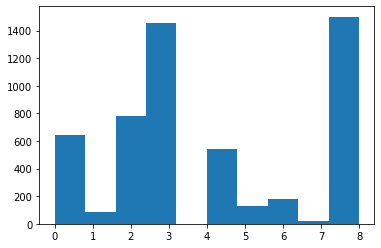

In [16]:
plt.hist(y_test)
plt.show()

100%|██████████| 11/11 [00:01<00:00, 10.91it/s]


4974/5328 correct
Test ACC: 0.933559, F1_macro: 0.895194, F1_weighted: 0.932836


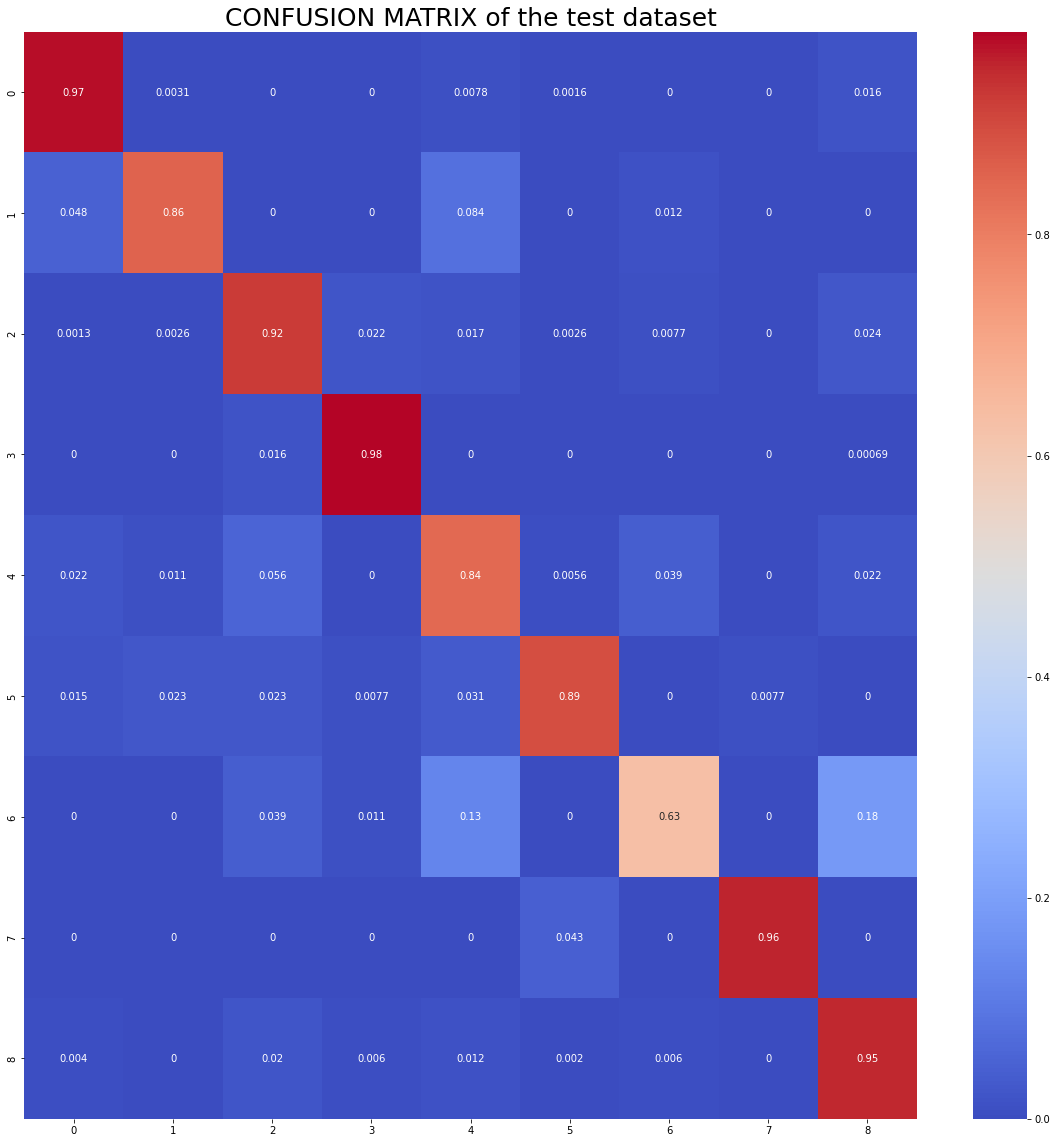

In [15]:
from torchvision.models import resnet50
import torch.nn as nn 
from sklearn.metrics import confusion_matrix

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
test(model, test_loader)